In [1]:
from scipy import signal as sg
import matplotlib.pyplot as plt
import numpy as np
import scipy.optimize
import control as ct


In [2]:
dados_recebidos = np.load(r"Dados_SK.npy")
tempo_medido = dados_recebidos[:,0]
Ts = np.mean(tempo_medido).round(4)
Ts

0.0156

In [4]:
R1 = 984
R2 = 9.88e3
C1 = 3.303e-6
C2 = 3.353e-6

w0 = np.sqrt(1/(C1*C2*R1*R2))
xi = (1/(2*w0))*((1/(R1*C1))+(1/(R2*C2)))
xi

num = w0**2
den = [1,2*xi*w0, w0**2]
H = ct.tf(num,den)
Hz = ct.c2d(H,Ts,'zoh')
Hz

TransferFunction(array([0.30853126, 0.06394089]), array([ 1.        , -0.63266795,  0.00514011]), 0.0156)

25


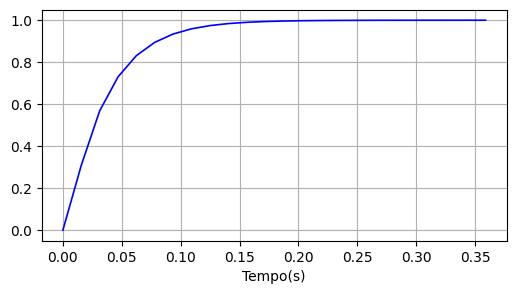

In [5]:
TempoTotal = 0.4
Ns = int(TempoTotal/Ts)
t = Ts*np.arange(0,Ns-1)
yc = ct.step_response(H,T=t)[1]
plt.figure(figsize=(6,3))
plt.plot(t,yc,'-b',linewidth=1.2)
plt.xlabel('Tempo(s)')
plt.grid()

print(Ns)


# Identificação

In [6]:
sinal_entrada = dados_recebidos[:,1]
sinal_saida = dados_recebidos[:,2]

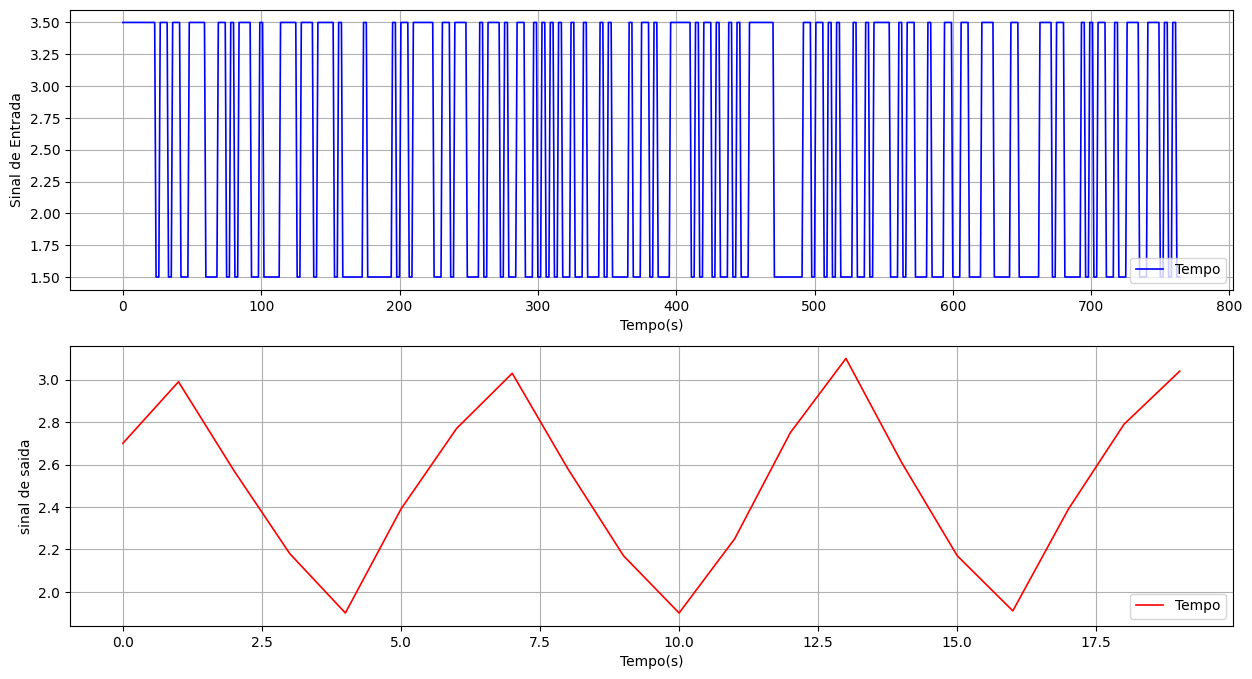

In [7]:
plt.figure(figsize=(15,8))
plt.subplot(211)
plt.plot(sinal_entrada,'-b',linewidth=1.2)
plt.xlabel('Tempo(s)')
plt.ylabel('Sinal de Entrada')
plt.grid()
plt.legend(loc='lower right', labels=('Tempo','Sinal de entrada'))


sinal_saida[102] = (sinal_saida[101]+ sinal_saida[103])/2
sinal_saida[146] = (sinal_saida[145]+ sinal_saida[147])/2
sinal_saida[203] = (sinal_saida[202]+ sinal_saida[204])/2
sinal_saida[313] = 3.1
sinal_saida[480] = (sinal_saida[479]+ sinal_saida[481])/2
#sinal_saida[550] = (sinal_saida[655]+ sinal_saida[657])/2
sinal_saida[656] = (sinal_saida[655]+ sinal_saida[657])/2

plt.subplot(212)
plt.plot(sinal_saida[300:320],'r',linewidth=1.2)
plt.xlabel('Tempo(s)')
plt.ylabel('sinal de saida')
plt.grid()
plt.legend(loc='lower right', labels=('Tempo','Sinal de saida'))
plt.savefig('SINAL_PRBS.png',bbox_inches='tight')
plt.show()

In [8]:
Nt = 25
ur =sinal_entrada[Nt-1:-1]-2.5
yr = sinal_saida[Nt:]-np.mean(sinal_saida[Nt:])
y0 = sinal_saida[Nt-2:Nt]-np.mean(sinal_saida[Nt:])
N = len(ur)
t = Ts*np.arange(0,N)

y0

array([1.00593919, 1.00593919])

In [9]:
percIdent = 0.7         # Percentual dos dados de identificação:
Ni = int(percIdent*N)   # Quantidade de amostras para identificação:
Ni

518

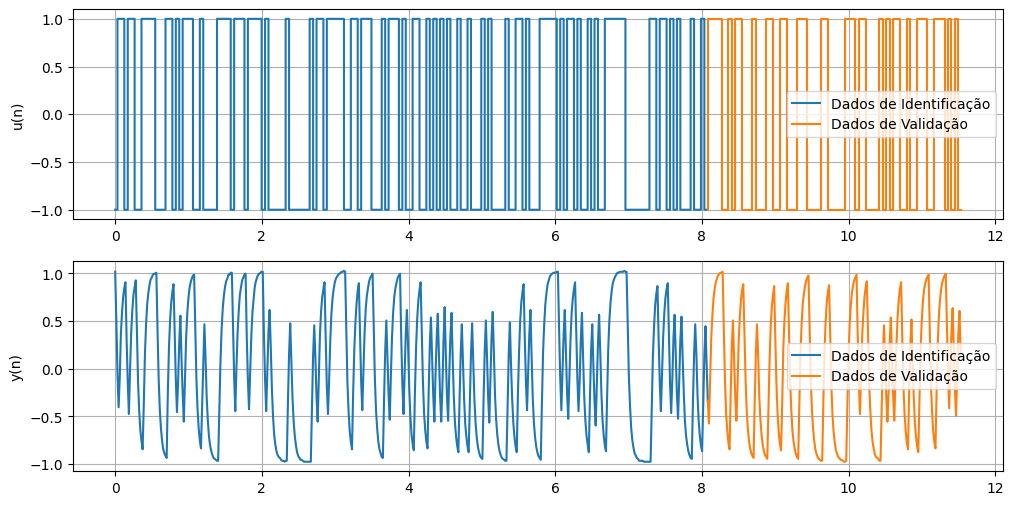

In [10]:
plt.figure(figsize = (12,6))
plt.subplot(211)
plt.step(t[:Ni+1],ur[:Ni+1],label='Dados de Identificação')
plt.step(t[Ni:],ur[Ni:],label='Dados de Validação')
plt.ylabel('u(n)')
plt.legend()
plt.grid()
plt.subplot(212)
plt.plot(t[:Ni+1],yr[:Ni+1], label='Dados de Identificação')
plt.plot(t[Ni:],yr[Ni:],label='Dados de Validação')
plt.legend()
plt.grid()
plt.ylabel('y(n)')
plt.savefig('validação.png',bbox_inches='tight')
plt.show()

Hz

In [211]:
Hz

TransferFunction(array([0.30853126, 0.06394089]), array([ 1.        , -0.63266795,  0.00514011]), 0.0156)

In [11]:
# Matriz de regressão:
nb = 2          #atraso em b
na = 2          #atraso em a
ni = np.arange(na,Ni+na)
M = np.zeros((Ni,na+nb))

M.shape

(518, 4)

In [12]:
# Regressores da saida y:
M[:,0] = yr[ni-1]
M[:,1] = yr[ni-2]

# Regressores da entrada u:
M[:,2] = ur[ni-1]
M[:,3] = ur[ni-2]

In [13]:
# Mínimos quadrados
theta = np.linalg.inv(M.T@M)@M.T@yr[ni]

theta

array([ 0.64008682, -0.00991776,  0.29463184,  0.07316346])

In [14]:
A = np.array([1, -theta[0],-theta[1]])
B = np.array([theta[2], theta[3]])
Gz = ct.tf(B,A,dt = Ts)
print(Gz)
print(Hz)


   0.2946 z + 0.07316
-------------------------
z^2 - 0.6401 z + 0.009918

dt = 0.0156


   0.3085 z + 0.06394
------------------------
z^2 - 0.6327 z + 0.00514

dt = 0.0156



In [15]:
# yp = sg.dlsim(Gz, sinal_entrada, t = t)[1]
t = Ts*np.arange(0,N)
_, ys = ct.forced_response(Hz, T=t,U = ur,X0 = y0)
_, yp = ct.forced_response(Gz, T=t,U = ur)


len(yr)

c:\Users\Raphael\AppData\Local\Programs\Python\Python311\Lib\site-packages\control\timeresp.py:946: UserWarning: Non-zero initial condition given for transfer function system. Internal conversion to state space used; may not be consistent with given X0.
  warnings.warn(


740

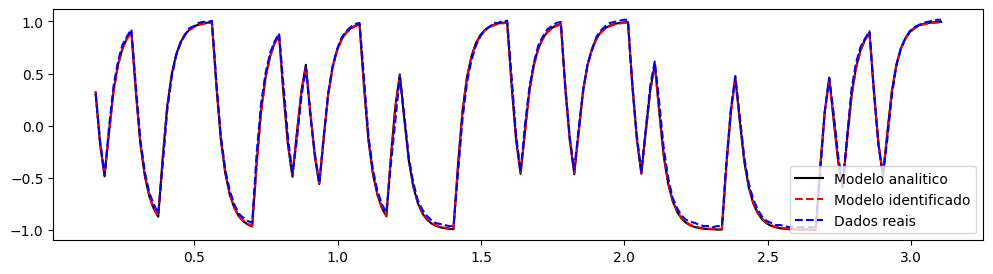

In [16]:
from sklearn.metrics import r2_score as AjusteR2
# Resposta do modelo identificado:
inicio = 10
fim = 200
plt.figure(figsize = (12,3))
plt.plot(t[inicio:fim],ys[inicio:fim],'k-',label='Modelo analitico')
plt.plot(t[inicio:fim],yp[inicio:fim],'r--',label='Modelo identificado')
plt.plot(t[inicio:fim],yr[inicio:fim],'b--',label='Dados reais')
plt.legend(loc='lower right')

plt.show()

In [18]:
print('Ajuste Analitico x Identificado: ', AjusteR2(ys,yp).round(3))
print('Ajuste Analitico x Dados reais: ', AjusteR2(ys,yr).round(3))
print('Ajuste Identificado x Dados reais: ', AjusteR2(yp,yr).round(3))

Ajuste Analitico x Identificado:  0.999
Ajuste Analitico x Dados reais:  0.994
Ajuste Identificado x Dados reais:  0.991


In [19]:
print('Analítico H(z) = ', Hz, 'Identificado G(z) = ', Gz)

Analítico H(z) =  
   0.3085 z + 0.06394
------------------------
z^2 - 0.6327 z + 0.00514

dt = 0.0156
 Identificado G(z) =  
   0.2946 z + 0.07316
-------------------------
z^2 - 0.6401 z + 0.009918

dt = 0.0156

